# Building the distributed seismicity model

Notes:
* The catalogue used for the smoothing contains only earthquakes with magnitude larger than the 'cutoff_magnitude' parameter defined in the .ini file of the project

In [1]:
%matplotlib inline
import os
import h5py
import numpy
import scipy
import pickle
import matplotlib.pylab as plt
from decimal import *
getcontext().prec = 4

from copy import deepcopy

from oqmbt.oqt_project import OQtProject, OQtSource
from oqmbt.tools.area import create_catalogue
from oqmbt.tools.smooth import Smoothing
from oqmbt.tools.mfd import get_evenlyDiscretizedMFD_from_truncatedGRMFD

from openquake.hazardlib.source import PointSource, SimpleFaultSource
from oqmbt.tools.geo import get_idx_points_inside_polygon
from openquake.hazardlib.mfd.evenly_discretized import EvenlyDiscretizedMFD
from openquake.hazardlib.mfd.truncated_gr import TruncatedGRMFD
from openquake.hazardlib.geo.point import Point
from openquake.hazardlib.geo.geodetic import azimuth, point_at

from openquake.hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.scalerel.wc1994 import WC1994
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.geo.nodalplane import NodalPlane 

from oqmbt.notebooks.sources_distributed_s.utils import get_xy, get_polygon_from_simple_fault

In [2]:
%%bash
rm tmp*

rm: tmp*: No such file or directory


In [4]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
print('Active model ID is:', model_id)

Active model ID is: model1


In [5]:
src_id = getattr(oqtkp,'active_source_id')[0]
print('Area source ID:', src_id)
src = model.sources[src_id]

Area source ID: 11


## Set the nodal plane distribution 

In [6]:
# 
# set the nodal plane distribution
nodal_plane_dist_filename = os.path.join(oqtkp.directory, model.nodal_plane_dist_filename)
fhdf5 = h5py.File(nodal_plane_dist_filename,'a')
#
# add the dataset for the current area source, if missing
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['strike'][0] == 0) and 
                                    (fhdf5[src_id]['dip'][0] == 0) and
                                    (fhdf5[src_id]['rake'][0] == 0))):
    print('Using source-specific nodal plane distribution')
    data = fhdf5[src_id][:]
    tpll = []    
    for idx in range(0, len(data)):
        nplane = NodalPlane(data['strike'][idx],
                            data['dip'][idx],
                            data['rake'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
else:
    print('Using default nodal plane distribution')
    tpll = []
    npd = model.default_nodal_plane_dist
    for idx in range(0, len(npd['strike'])):
        nplane = NodalPlane(npd['strike'][idx],
                            npd['dip'][idx],
                            npd['rake'][idx])
        # tmp = float(data['wei'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
nodal_plane_distribution = PMF(tpll)    
fhdf5.close()

Using source-specific nodal plane distribution


## Set the hypocentral depth distribution

In [7]:
# 
# read hypocentral depth file
hypo_dist_filename = os.path.join(oqtkp.directory, model.hypo_dist_filename)
fhdf5 = h5py.File(hypo_dist_filename,'a')
#
# check if the file contains information relative this source
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['depth'][0] == 0) and 
                                    (fhdf5[src_id]['wei'][0] == 0))):
    print('Using source-specific hypocentral depth distribution')
    data = fhdf5[src_id][:]
    tpll = []
    for idx in range(0, len(data)):
        #tmp = float(data['wei'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), data['depth'][idx]))
else:
    print('Using default hypocentral depth distribution')
    tpll = []
    hdd = model.default_hypo_dist
    for idx in range(0, len(hdd['dep'])):
        # tmp = float(hdd['wei'][idx])
        tmp = Decimal('{:.2f}'.format(hdd['wei'][idx]))
        tpll.append((Decimal(tmp), hdd['dep'][idx]))
hypocenter_distribution = PMF(tpll)    

Using source-specific hypocentral depth distribution


## Parameters

In [8]:
area_discretization = model.area_discretization 
buff = 2.0
faults_lower_threshold_magnitude = model.faults_lower_threshold_magnitude

## Create the dilated polygon around the area source
NOTE: We don't necessarily need to use the polygon of the area source. In a future version the polygon must be defined in the configuration file or computed automatically.

In [9]:
new_polygon = src.polygon.dilate(100)
polygon_mesh = new_polygon.discretize(area_discretization)
print('Number of points: %d' % (len(polygon_mesh)))

Number of points: 4633


## Get the earthquakes within the dilated polygon

In [10]:
# First we get the earthquakes of the catalogue within the dilated polygon 
pickle_filename = os.path.join(oqtkp.directory, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print('The calogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

The calogue contains 3147 earthquakes


In [11]:
# Then we create the subcatalogue for the dilated polygon
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
fcatal = create_catalogue(model, catalogue, polygon=new_polygon)
selector = CatalogueSelector(catalogue, create_copy=False)
selector.within_magnitude_range(cutoff_magnitude, 10.)

In [12]:
# Compute scaling factor based on completeness - For the time being we don't consider this.
scalf = numpy.ones((len(fcatal.data['magnitude'])))

## Smoothing 

In [13]:
smooth_param = model.smoothing_param
smooth = Smoothing(fcatal, polygon_mesh, 10)

In [14]:
dir(smooth.get_points_in_polygon)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [15]:
values = smooth.gaussian(50, 20)
print('Max of smoothing:', max(values))
values = smooth.multiple_smoothing(smooth_param)
print('Max of smoothing:', max(values))

Max of smoothing: 0.642396588948
Max of smoothing: 0.705122909889


In [16]:
lons_mesh = smooth.mesh.lons
lons_mesh_sh = ([x+360 if x<0 else x for x in lons_mesh])
smooth.mesh.lons = numpy.array(lons_mesh_sh)

lons_poly = src.polygon.lons
lons_poly_sh = ([x+360 if x<0 else x for x in lons_poly])


lons_cat = fcatal.data['longitude']
lons_cat_sh = ([x+360 if x<0 else x for x in lons_cat]) 
fcatal.data['longitude'] = lons_cat_sh

(-21.167999999999999, -11.9425765042743)

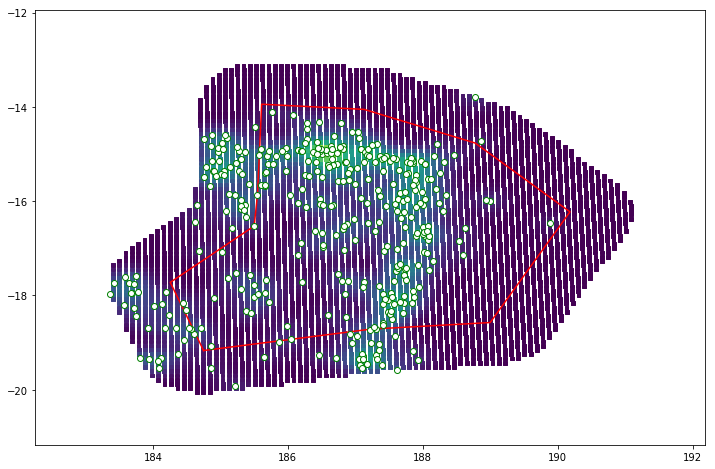

In [18]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot((111))
#
# plotting
plt.scatter(smooth.mesh.lons, smooth.mesh.lats, c=values, vmin=0, vmax=max(values), marker='s', s=15)
plt.plot(lons_poly_sh, src.polygon.lats, 'r')
plt.plot(fcatal.data['longitude'], fcatal.data['latitude'], 'og', mfc='white')
#
# find min and max longitude and latitude of the area source polygon
lomin = min(lons_poly_sh) - buff
lamin = min(src.polygon.lats) - buff
lomax = max(lons_poly_sh) + buff
lamax = max(src.polygon.lats) + buff
#
# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

In [19]:
%%bash
rm tmp*

## Select the nodes of the grid within the area source

In [20]:
idxp = smooth.get_points_in_polygon(src.polygon)

### Plotting

(-21.167999999999999, -11.9425765042743)

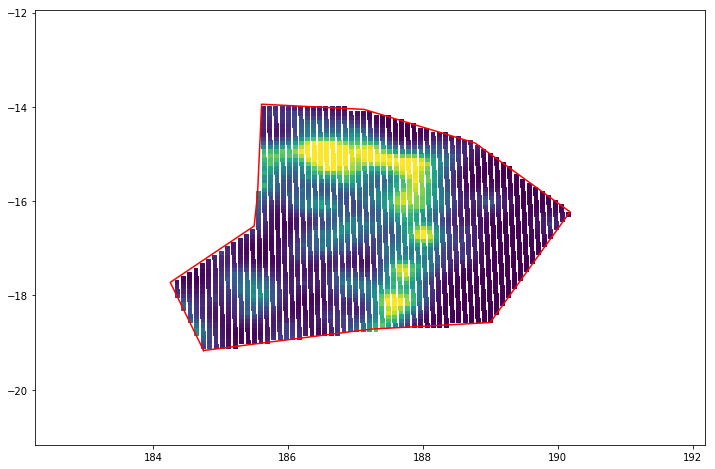

In [22]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot((111))
plt.scatter(smooth.mesh.lons[idxp], smooth.mesh.lats[idxp], vmin=0, vmax=0.4, c=values[idxp], marker='s', s=15)
plt.plot(lons_poly_sh, src.polygon.lats, 'r')
if 'ids_faults_inside' in src.__dict__:
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
        tsrc = model.sources[key] 
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        coord_sh = ([x+360 if x<0 else x for x in coord[:,0]])
        plt.plot(coord_sh[:], coord[:,1], 'r')
#
# fix axes limits
ax.set_xlim([lomin, lomax])
ax.set_ylim([lamin, lamax])

## Assigning seismicity to the source
The redistribution of seismicity to the source is done for each cell using as a scaling factor the ratio of the value assigned to the node and the sum of the values of all the nodes within the area source. Note that the mfd assigned to the area source must be an EvenlyDiscretisedMFD instance.

In [23]:
scaling_factor = 1. /sum(values[idxp])
if isinstance(src.mfd, TruncatedGRMFD):
    newmfd = get_evenlyDiscretizedMFD_from_truncatedGRMFD(src.mfd)
    src.mfd = newmfd
mfdpnts = numpy.array([src.mfd.occurrence_rates]*len(values))*scaling_factor
#
#
xxx = numpy.tile(values, (mfdpnts.shape[1], 1)).T
mfdpnts = mfdpnts * numpy.tile(values, (mfdpnts.shape[1], 1)).T
#
# 
mags = []
for mag, _ in src.mfd.get_annual_occurrence_rates():
    mags.append(mag)   

## Cutting the MFDs of the point sources close to faults

Source: sf_104
Source: sf_107
Source: sf_108


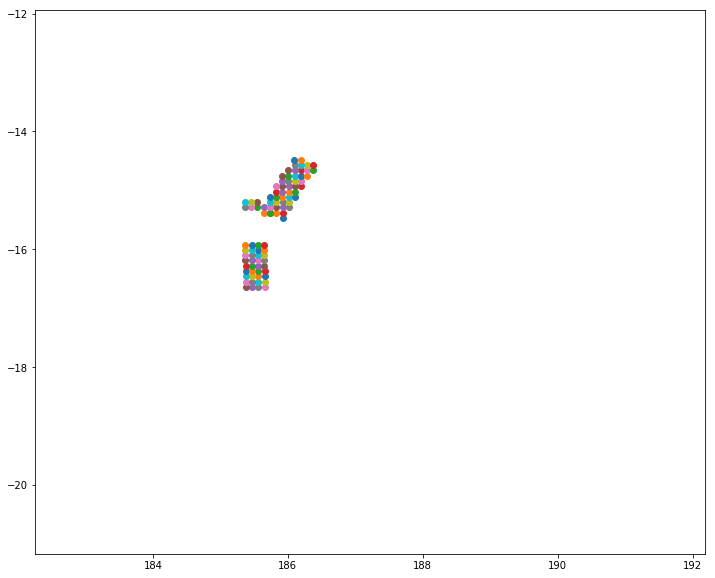

In [24]:
faultcheck = False
inc_faults = len(src.ids_faults_inside)
if inc_faults>0:
    faultcheck = True
    
    
if faultcheck == True: 
    # find index of magnitudes above the threshold
    jjj = numpy.nonzero(numpy.array(mags) > faults_lower_threshold_magnitude)
    chng = numpy.zeros_like((values))
    #
    # create figure
    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)
    #
    #
    if hasattr(src, 'ids_faults_inside'):
        for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
            #
            # Getting the fault source
            tsrc = model.sources[key]
            print('Source:', key)

            if 'mfd' in tsrc.__dict__ and tsrc.mfd is not None:

                lons, lats = get_xy(tsrc.trace) 
                lons = ([x+360 if x<0 else x for x in lons])

                # Create the polygon representing the surface projection of the fault
                # surface
                coord = numpy.array(get_polygon_from_simple_fault(tsrc))
                #
                #
                min_lon = numpy.min(lons)-buff
                max_lon = numpy.max(lons)+buff
                min_lat = numpy.min(lats)-buff
                max_lat = numpy.max(lats)+buff

                idxs = list(smooth.rtree.intersection((min_lon, min_lat, max_lon, max_lat)))

                iii = get_idx_points_inside_polygon(smooth.mesh.lons[idxs], 
                                                    smooth.mesh.lats[idxs],
                                                    list(coord[:,0]), 
                                                    list(coord[:,1]), 
                                                    idxs,
                                                    15000.0) 

                for tidx in iii:
                    plt.plot(smooth.mesh.lons[tidx], smooth.mesh.lats[tidx], 'o')
                    mfdpnts[tidx, jjj] = 0.
                    chng[tidx] = 1.

    plt.plot(lons_poly_sh, src.polygon.lats, 'g', lw=4)
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
            tsrc = model.sources[key]
            lons, lats = get_xy(tsrc.trace) 
            coord = numpy.array(get_polygon_from_simple_fault(tsrc))
            coord_sh = ([x+360 if x<0 else x for x in coord[:,0]])
            plt.plot(coord_sh[:], coord[:,1], 'r')
    #
    # fix axes limits
    ax.set_xlim([lomin, lomax])
    ax.set_ylim([lamin, lamax])

## Map

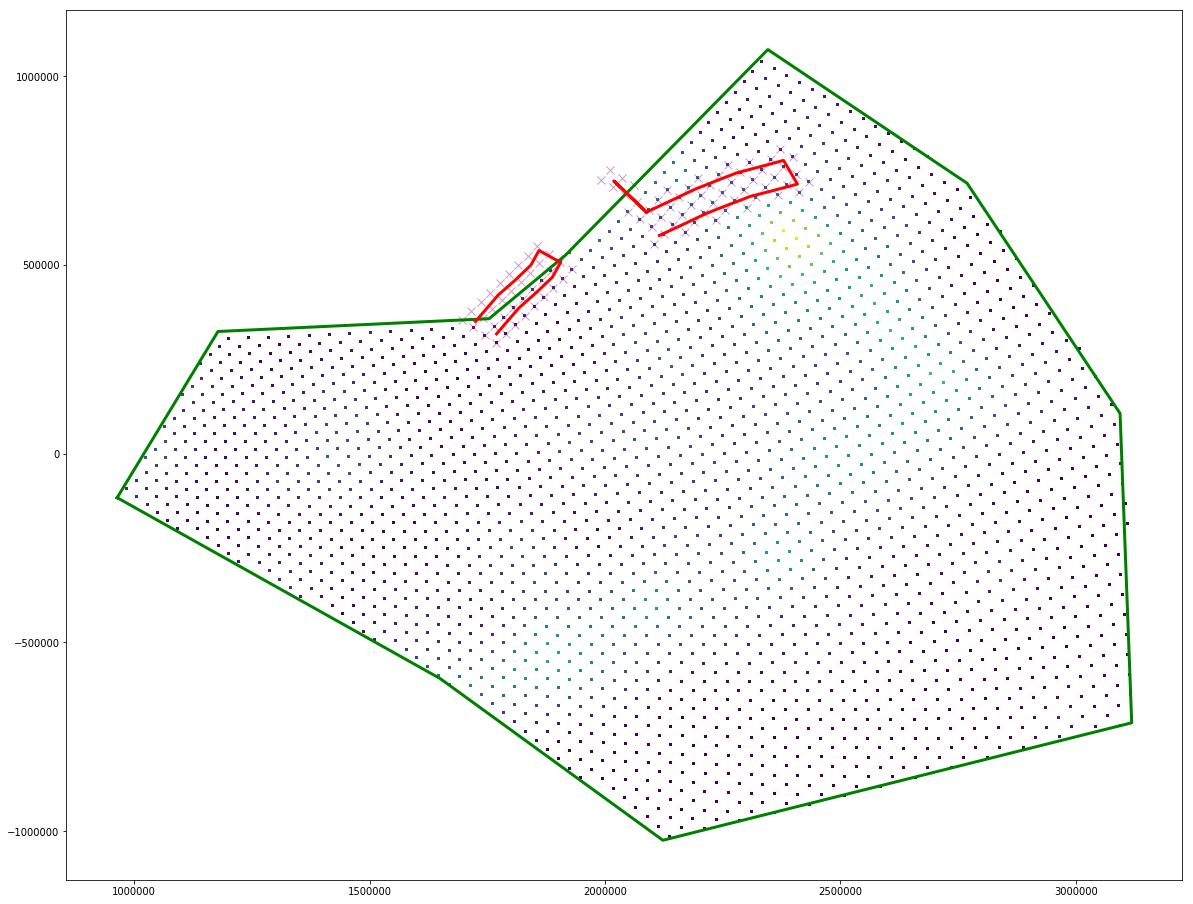

In [25]:
if faultcheck == True:
    from mpl_toolkits.basemap import Basemap
    meanlon = 0.5*(lomin+lomax)
    meanlat = 0.5*(lamax+lamin)

    fig = plt.figure(figsize=(20,16))
    m = Basemap(llcrnrlon=lomin,
                llcrnrlat=lamin,
                urcrnrlon=lomax,
                urcrnrlat=lamax,
                resolution='i',
                projection='tmerc',
                lon_0 = meanlon,
                lat_0 = meanlat)
                #lon_0=106,
                #lat_0=28)

    #m.shadedrelief()
    x, y = m(smooth.mesh.lons, smooth.mesh.lats)
    rtes = numpy.sum(mfdpnts, axis=1)
    plt.scatter(x[idxp], y[idxp], s=9, marker='s', c=rtes[idxp], lw=0.)

    parallels = numpy.arange(lamin, lamax, 5.)
    #m.drawparallels(parallels,labels=[False,True,True,False])
    meridians = numpy.arange(90, lomax, 5.)
    #m.drawmeridians(meridians,labels=[True,False,False,True])

    jjj = numpy.nonzero(chng > 0)
    plt.plot(x[jjj], y[jjj], 'x', lw=0.8, alpha=0.4, ms=8, markerfacecolor='None', markeredgecolor='purple')

    x, y = m(src.polygon.lons, src.polygon.lats)        
    plt.plot(x, y, 'g', lw=3)

    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())):     
        tsrc = model.sources[key]
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        x, y = m(coord[:,0], coord[:,1])
        if 'mfd' in tsrc.__dict__ and tsrc.mfd is not None:
            plt.plot(x, y, 'r', lw=3)
        else:
            plt.plot(x, y, '-', color='pink')

In [26]:
lons_sh = smooth.mesh.lons
lons_un = ([x-360 if x>180 else x for x in lons_sh])
smooth.mesh.lons = numpy.array(lons_un)

# Create the nrml sources 

In [27]:
nrmls = [] 

import importlib
module = importlib.import_module('openquake.hazardlib.scalerel')
my_class = getattr(module, model.msr)
magnitude_scaling_relationship = my_class()

rupture_mesh_spacing = model.fault_rupture_mesh_spacing
rupture_aspect_ratio = model.fault_rupt_aspect_ratio
temporal_occurrence_model = PoissonTOM(1.)

for eee, iii in enumerate(idxp):
    jjj = numpy.nonzero(mfdpnts[iii, :] > 0)
    
    if len(list(mfdpnts[iii, jjj][0])) > 0:
        tmfd = EvenlyDiscretizedMFD(src.mfd.min_mag, src.mfd.bin_width, list(mfdpnts[iii, jjj][0]))

        points = PointSource(
            source_id='%d' % eee, 
            name='', 
            tectonic_region_type=src.tectonic_region_type,
            mfd=tmfd, 
            rupture_mesh_spacing=rupture_mesh_spacing,
            magnitude_scaling_relationship=magnitude_scaling_relationship, 
            rupture_aspect_ratio=rupture_aspect_ratio,
            temporal_occurrence_model=temporal_occurrence_model,
            upper_seismogenic_depth=model.upper_seismogenic_depth, 
            lower_seismogenic_depth=src.lower_seismogenic_depth,
            location=Point(smooth.mesh.lons[iii], smooth.mesh.lats[iii]), 
            nodal_plane_distribution=nodal_plane_distribution, 
            hypocenter_distribution=hypocenter_distribution
            )
        nrmls.append(points)

In [28]:
import re
from openquake.hazardlib.sourcewriter import write_source_model
# Write the nrml file
model_dir = os.path.join(oqtkp.directory, 'nrml/%s' % (re.sub('\s','_',model_id)))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_name = 'gridded_seismicity_source_%s.xml' % (src_id)
out_model_name = os.path.join(model_dir, model_name)
_ = write_source_model(out_model_name, nrmls, 'Model %s')
print('Created %s ' % (out_model_name))

Created /Users/kjohnson/GEM/Regions/pacisl18/data/catalogues/locations-adjust-slab/Kerton-testing/project_test1/nrml/model1/gridded_seismicity_source_11.xml 
